In [37]:
import torch
from torch import nn
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

In [38]:
#Dowload training data from open datasets
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [39]:
# Create data loaders
train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

for X,y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [40]:
# Creating model
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

#Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512,512),
            nn.ReLU(),
            nn.Linear(512,10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [41]:
#Optimizing the model parameters
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [42]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    total_loss = 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()   # reset gradients
        loss.backward()
        optimizer.step()

        # Ghi nhận loss
        total_loss += loss.item()

        if batch % 100 == 0:
            current = (batch + 1) * len(X)
            print(f"loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")

    # Tính loss trung bình sau khi epoch kết thúc
    avg_loss = total_loss / len(dataloader)
    print(f"Average training loss: {avg_loss:.4f}")
    return avg_loss


In [43]:
#Test loop
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [44]:
# Training + track loss
import matplotlib.pyplot as plt

epochs = 5
train_losses = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
    train_losses.append(train_loss)

print("Done!")

Epoch 1
-------------------------------
loss: 2.297323  [   64/60000]
loss: 2.293706  [ 6464/60000]
loss: 2.274116  [12864/60000]
loss: 2.265240  [19264/60000]
loss: 2.247516  [25664/60000]
loss: 2.216133  [32064/60000]
loss: 2.215987  [38464/60000]
loss: 2.181884  [44864/60000]
loss: 2.176747  [51264/60000]
loss: 2.145370  [57664/60000]
Average training loss: 2.2262
Test Error: 
 Accuracy: 51.3%, Avg loss: 2.140332 

Epoch 2
-------------------------------
loss: 2.141629  [   64/60000]
loss: 2.144020  [ 6464/60000]
loss: 2.079371  [12864/60000]
loss: 2.103610  [19264/60000]
loss: 2.047415  [25664/60000]
loss: 1.983229  [32064/60000]
loss: 2.007242  [38464/60000]
loss: 1.925161  [44864/60000]
loss: 1.928908  [51264/60000]
loss: 1.859448  [57664/60000]
Average training loss: 2.0110
Test Error: 
 Accuracy: 61.1%, Avg loss: 1.855879 

Epoch 3
-------------------------------
loss: 1.881280  [   64/60000]
loss: 1.861425  [ 6464/60000]
loss: 1.734812  [12864/60000]
loss: 1.786080  [19264/600

In [45]:
#Saving model
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [46]:
#Loading model
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth", weights_only=True))

<All keys matched successfully>

In [47]:
#This model can now be used to make predictions.
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


# Task
○ Experiment with network/hyperparameters. 

○ Visualize loss. 

○ Display predicted vs actual images.

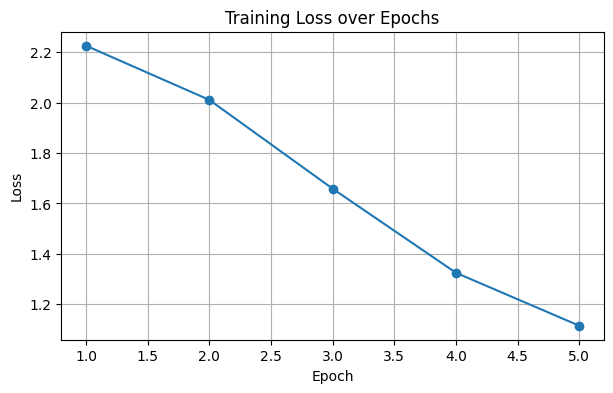

In [48]:
#Visualie loss
plt.figure(figsize=(7,4))
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

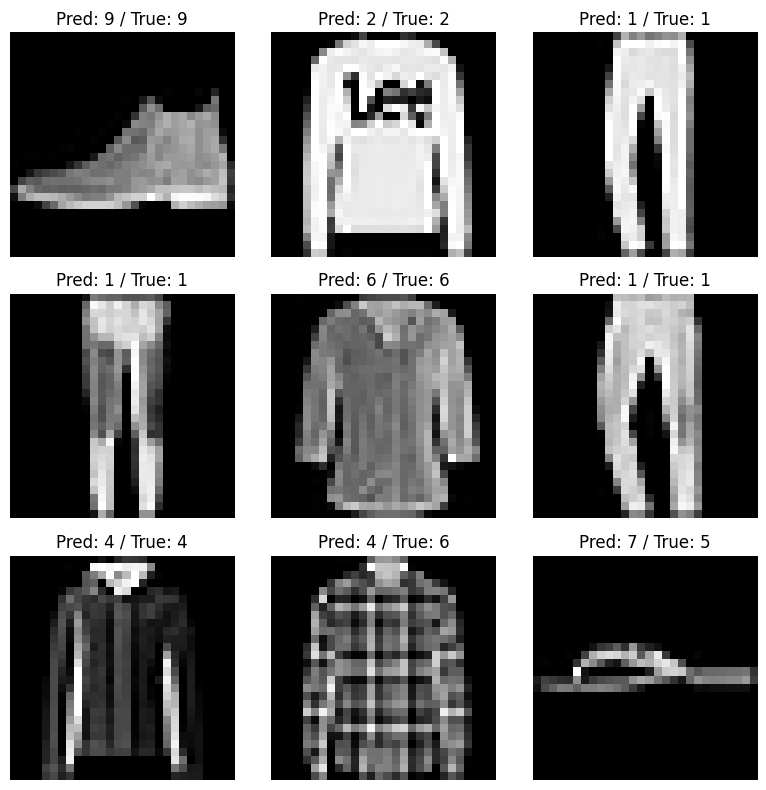

In [49]:
# --- Display predicted vs actual images ---
import matplotlib.pyplot as plt
import numpy as np

# Đặt model sang chế độ đánh giá (evaluation)
model.eval()

# Lấy 1 batch từ test_dataloader
dataiter = iter(test_dataloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Dự đoán
with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

# Hiển thị 9 ảnh đầu tiên
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i][0].cpu().numpy(), cmap='gray')  # nếu ảnh là grayscale (như MNIST)
    ax.set_title(f"Pred: {preds[i].item()} / True: {labels[i].item()}")
    ax.axis('off')

plt.tight_layout()
plt.show()
